# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sound import allDone

In [2]:
artist_data = pd.read_csv("./data/lastfm/artists.dat", sep="\t", index_col=["id"])
artist_data.head()

,name,url,pictureURL
id,,,
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [3]:
user_artist_plays = pd.read_csv("./data/lastfm/user_artists.dat", sep="\t")
user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

### Los 20 artistas que mas usuarios escucharon fue:

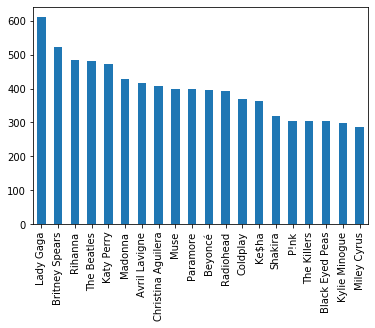

In [4]:
artists = user_artist_plays["artistID"].value_counts()[:20]
artists.index = artist_data.loc[artists.index]["name"].values
artists.plot(kind="bar")

### Los 20 artistas que mas cantidad de veces fueron escuchados son:

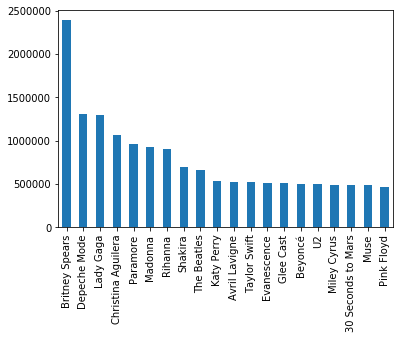

In [5]:
artists = user_artist_plays.groupby("artistID")["weight"].agg(sum).sort_values(ascending=False)[:20]
artists.index = artist_data.loc[artists.index]["name"].values
artists.plot(kind="bar")

### Distribucion de cantidad de listens por user

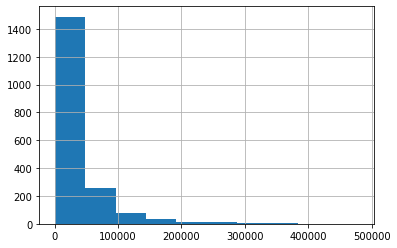

In [6]:
user_artist_plays.groupby("userID")["weight"].agg(sum).hist()

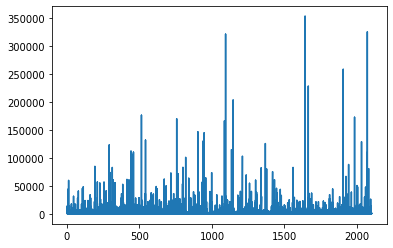

In [7]:
plt.plot(user_artist_plays["userID"], user_artist_plays["weight"])

### Genero mas escuchado

En principio no es posible obtener los generos de cada banda. Lo único que tenemos son los tags que los usuarios le asignaron.

## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

df_aux = pd.DataFrame(index = set(user_artist_plays["userID"].values))
for i in tqdm(set(user_artist_plays["artistID"].values)):
    df_aux[i] = 0
df_aux.loc[user_artist_plays["userID"], user_artist_plays["artistID"]] = user_artist_plays["weight"]

df_aux = pd.read_csv("UserContentMatrix.csv")

df_aux = pd.DataFrame(index = set(user_artist_plays["userID"].values))
for i in tqdm(range(len(user_artist_plays))):
    aux = user_artist_plays[user_artist_plays.index == i]
    df_aux[aux["artistID"].values[0]] = 0
    df_aux.loc[aux["userID"].values[0], aux["artistID"].values[0]] = aux["weight"].values[0]
df_aux
df_aux.to_csv("UserContentMatrix.csv")

In [8]:
total_weight_by_user = user_artist_plays[["userID", "weight"]].groupby("userID").agg(sum)

In [9]:
user_artist_plays["normalized_weight"] = (user_artist_plays.set_index("userID")["weight"] / total_weight_by_user["weight"]).values

In [10]:
reader = Reader(rating_scale = (user_artist_plays["weight"].min(), user_artist_plays["weight"].max()))
data = Dataset.load_from_df(user_artist_plays[['userID', 'artistID', 'normalized_weight']], reader)

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

El mejor resultado lo da Baseline.

In [11]:
results = {}

### KNNBasic

In [12]:
search_params = {
    "k": [10],
    "sim_options": {'name': ['cosine', "msd", "pearson", "pearson_baseline"],'user_based': [False] },
}
gs = GridSearchCV(KNNBasic, search_params, measures=["rmse", "mae"], cv=3)
gs.fit(data)
results["knn"] = gs

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

### kNN with Means

In [13]:
search_params = {
    "k": [10],
    "sim_options": {'name': ['cosine', "msd", "pearson", "pearson_baseline"],'user_based': [False] },
}
gs = GridSearchCV(KNNWithMeans, search_params, measures=["rmse", "mae"], cv=3)
gs.fit(data)
results["knn_means"] = gs

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

### kNN with ZScore

In [14]:
search_params = {
    "k": [10],
    "sim_options": {'name': ['cosine', "msd", "pearson", "pearson_baseline"],'user_based': [False] },
}
gs = GridSearchCV(KNNWithZScore, search_params, measures=["rmse", "mae"], cv=3)
gs.fit(data)
results["knn_zs"] = gs

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

In [15]:
for k, v in results.items():
    print(k, v.best_score)
    
allDone()

knn {'rmse': 0.9803311975512101, 'mae': 0.9796195395975352}
knn_means {'rmse': 0.9803312166188415, 'mae': 0.9796195369512706}
knn_zs {'rmse': 0.980331196108966, 'mae': 0.9796195346821226}


## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [29]:
model = results["knn_means"].best_estimator["rmse"]

model = KNNWithZScore(k= 10, sim_options={'name': 'pearson', 'user_based': True})

In [30]:
model.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [31]:
def get_artist_name(artist_id, artists_data):
    return artist_data.loc[artist_id]["name"]


def get_artist_id(artist_name, artists_data):
    result = artist_data[artist_data["name"] == artist_name].index.values
    return result[0]

In [32]:
def get_similar_artists(artist_name, artists_data, model, k = 10):
    id = get_artist_id(artist_name, artists_data)
    similar = model.get_neighbors(id, k)
    print(similar)
    for i in similar:
        print(get_artist_name(i, artists_data))

In [36]:
for i in user_artist_plays["artistID"].unique():
    if not i in artist_data.index.values:
        print(i)

In [39]:
get_similar_artists("Lady Gaga", artist_data, model)

[64, 94, 50, 51, 52, 53, 54, 55, 56, 57]
Röyksopp
Ministry of Sound
Gothminister
Duran Duran
Morcheeba
Air
Hooverphonic
Kylie Minogue
Daft Punk
Thievery Corporation
